In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 

np.random.seed(7)
np.set_printoptions(precision=4, suppress=True)  # 과학적 표기 대신 소숫점 자리 4자리까지 표현

rootDir = "/DockerProjects/Dataset/TUG/trainSet"
expertFolder = "/" + "HMM_saveResults_date_CYJ"  # --- 변경 할 부분
viewFolder = "/" + "0_sideView"

print(" [Home Dir.] Current path", os.getcwd())  

datasetDir = rootDir + expertFolder + viewFolder
os.chdir(datasetDir) ; print(" Current workaing path [dataset] ", os.getcwd())  # -- Dataset 있는 곳으로 경로 변경


numPelvis = 3 
numActions = 5

 [Home Dir.] Current path /DockerProjects/walkCAM/tug/temporalCNN_wLabel
 Current workaing path [dataset]  /DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_date_CYJ/0_sideView


In [2]:
def getLPF_PelvisData(csvFile):
    rawData = np.loadtxt(csvFile, delimiter=",")
    timestamp = rawData[:,0]
    pelvis_x = rawData[:,1]
    pelvis_y = rawData[:,2]
    pelvis_z = rawData[:,3]
    actionList = rawData[:,4:]
    return timestamp, pelvis_x, pelvis_y, pelvis_z, actionList

def sliding_window(timestamp, data_x, data_y, lookback_window=8):
    time = []
    x = []
    y = []
    enc = MinMaxScaler(feature_range = (0, 1))
    enc_y = enc.fit_transform(data_y)
    for i in range(lookback_window, len(data_x)+1):
        time.append(timestamp[i-1])
        x.append(data_x[i - lookback_window:i])
        y.append(data_y[i-1])
  
    x = np.array(x)
    x = x.reshape(-1, lookback_window, numPelvis, 1)
    
    y = np.array(y)
    time = np.array(time)
    return time, x, y, enc


def pltSkeleton(timeSec, pelvis_x, pelvis_y, pelvis_z, saveDir, saveFile,  actLabel, addFolder="raw"):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 7))
    title = addFolder + "_" + saveFile
    ax[0].set_title(title)
    ax[0].set_ylabel('Side axis(X) of Pelvis [mm]')
    ax[1].set_ylabel('Vertical axis(Y) of Pelvis [mm]')
    ax[2].set_ylabel('Depth Axis of Pelvis [mm]')
    ax[2].set_xlabel('Time [Sec]')
    ax[0].plot(timeSec, pelvis_x, "r--", lw=1, label="pelvis_x")
    ax[1].plot(timeSec, pelvis_y, "g--", lw=1, label="pelvis_y")
    ax[2].plot(timeSec, pelvis_z, "b--", lw=1, label="pelvis_z")
    
    fig.legend()
    plt.show()
    
    plt.close()

### Saved Model 복원

In [3]:
Test_Model = "/" + "Add_data_20210410-Time_14-40_acc_90"
MODEL_SAVE_FOLDER_PATH ="/DockerProjects/walkCAM/tug/0_temporalCNN_wLabel/Results" + expertFolder + Test_Model + "/Model"
checkpoint_path = "/DockerProjects/walkCAM/tug/0_temporalCNN_wLabel/Results" + expertFolder +Test_Model+"/" + "ModelLookBack- 8 Origin0101 ----  0.2553.hdf5"

batch_size = 512 

model = tf.keras.models.load_model(MODEL_SAVE_FOLDER_PATH+"/Origin_TCN_model")
model.load_weights(checkpoint_path)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8, 3, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 8, 3, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 8, 3, 32)     9248        conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 8, 3, 32)     320         input_2[0][0]                    
____________________________________________________________________________________________

## POST processing (DTW) 

In [4]:
from dtw import dtw
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import seaborn as sns



act_dict = {"sit":0, "sit-to-stand":1, "walk": 2, "turn": 3, "stand-to-sit":4}
answer_y = [act_dict["sit"], act_dict["sit-to-stand"], act_dict["walk"], act_dict["turn"], act_dict["walk"], act_dict["stand-to-sit"], act_dict["sit"] ]
target_names = ["sit", "sit-to-stand", "walk", "turn", "stand-to-sit"]

def post_process_DTW(pred_y, answer_y):
    dtw_index ={"walk":4, "stand-to-sit": 5, "sit": 6}
    dtw_alignment  = dtw(pred_y,answer_y, keep_internals=True)

    results =[]
    for elements in dtw_alignment.index2:
        if elements == dtw_index["walk"]: 
            elements = act_dict["walk"]
        elif elements == dtw_index["stand-to-sit"]:  #
            elements = act_dict["stand-to-sit"]
        elif elements == dtw_index["sit"]:  #
            elements =  act_dict["sit"]     
        results.append(elements)

    
    # 간혹.. dtw 결과가 1개 더 많이 나올 때 있음.. 걍 뒤에 하나 지워버려..
    if len(dtw_alignment.index2) > len(pred_y):
        new_result = results[:-1]
    else:
        new_result = results
        
    return dtw_alignment, new_result


def plot_postResults(answer_y, pred_y, results, title="dtw"):
    fig = plt.figure(figsize=(18,12))
    
    Gnd_fig = fig.add_subplot(2,3,1)
    Gnd_fig.set_title(" Ground Truth ")
    Gnd_fig.plot(answer_y, "g", label = "Ground Truth")
    plt.legend()
    
    pred_fig = fig.add_subplot(2,3,2)
    pred_fig.set_title(" Prediction Result (Before DTW) ")
    pred_fig.plot(pred_y, "b", label=" pred_y (before DTW)")
    plt.legend()
    
    dtw_fig = fig.add_subplot(2,3,3)
    dtw_fig.set_title(" PostProcessing Results (DTW) ")
    dtw_fig.plot(results, "r",  label="dtw_result")
    plt.legend()
    
    gnd_pred_fig = fig.add_subplot(2,3,4)
    gnd_pred_fig.set_title(" Comparison: Ground Truth vs Prediction")
    gnd_pred_fig.plot(answer_y, "g", label="Ground Truth") # linewidth=3
    gnd_pred_fig.plot(pred_y, "b--", label=" pred_y (before DTW)")
    plt.legend()
    
    pred_dtw_fig = fig.add_subplot(2,3,5)
    pred_dtw_fig.set_title(" Comparison: Prediction vs DTW alignment")
    pred_dtw_fig.plot(pred_y, "b--", label=" pred_y (before DTW)") # linewidth=3
    pred_dtw_fig.plot(results, "r", label=" dtw_result")
    plt.legend()
    
    gnd_dtw_fig = fig.add_subplot(2,3,6)
    gnd_dtw_fig.set_title(" Comparison: Ground Truth vs DTW alignment ")
    gnd_dtw_fig.plot(answer_y, "g--", label="Ground Truth")
    gnd_dtw_fig.plot(results, "r", label="dtw_result")  # linewidth=3
    
    plt.legend()
    plt.savefig(MODEL_SAVE_FOLDER_PATH+"/DTW_Comparison_" + title  + ".png")
    
def create_testdata(pelvis_csv, lookback_window = 8):
    test_x = np.zeros((0, lookback_window, numPelvis,1 ))
    test_y = np.zeros((0, numActions)) 
    
   
    timstamp_ms, lpfPelvis_x, lpfPelvis_y, lpfPelvis_z, oneHot_actionList  = getLPF_PelvisData(pelvis_csv)  # raw                 
    
    pelvisData = np.array([lpfPelvis_x, lpfPelvis_y, lpfPelvis_z]).T  # (335,3) 
    actionData = np.array(oneHot_actionList)    # # (335, 5)
                            
    blockTime, blockPelvis, blockLable, enc = sliding_window(timstamp_ms, data_x = pelvisData, data_y = actionData, lookback_window=lookback_window) 

    test_x = np.append(test_x, blockPelvis, axis = 0 )
    test_y = np.append(test_y, blockLable, axis = 0 )    

    return test_x, test_y

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### 정상인 20대, 30대, 60대 

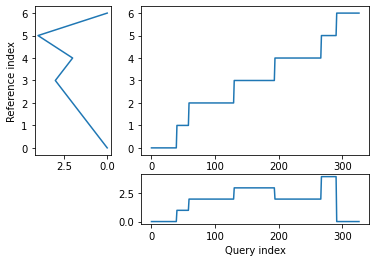

1/1 - 14s - loss: 0.1573 - accuracy: 0.9388
[Before DTW] 
               precision    recall  f1-score   support

         sit       0.96      0.97      0.97        76
sit-to-stand       0.89      0.84      0.86        19
        walk       0.92      0.99      0.95       144
        turn       1.00      0.84      0.92        64
stand-to-sit       0.91      0.88      0.89        24

    accuracy                           0.94       327
   macro avg       0.94      0.90      0.92       327
weighted avg       0.94      0.94      0.94       327

------------------------------
[After DTW] 
               precision    recall  f1-score   support

         sit       1.00      1.00      1.00        76
sit-to-stand       1.00      1.00      1.00        19
        walk       1.00      1.00      1.00       144
        turn       1.00      1.00      1.00        64
stand-to-sit       1.00      1.00      1.00        24

    accuracy                           1.00       327
   macro avg       1.00    

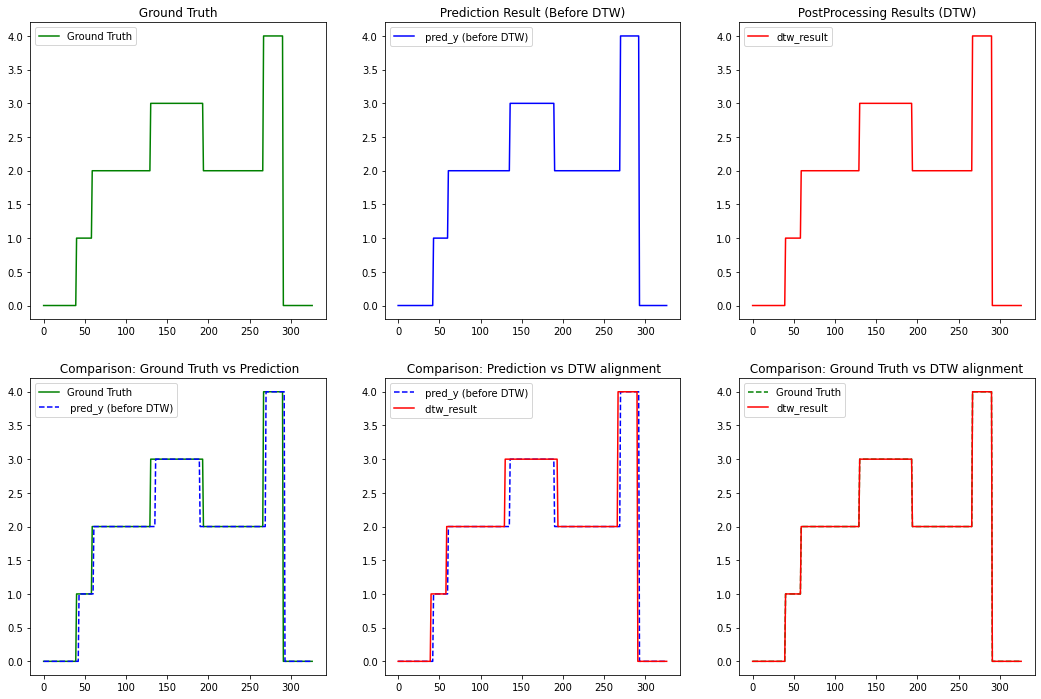

In [5]:
test_normal_20 = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2020_11_03 TUG/bys_tug/001/Originact5_lpf_labeled_bys_tug_001.csv"
test_normal_20_x, test_normal_20_y_onehot = create_testdata(test_normal_20) 
test_normal_20_y = np.argmax(test_normal_20_y_onehot, axis=1).reshape(-1) # GND one-hot decode

pred_normal_20_y_onehot = model.predict(test_normal_20_x) 
pred_normal_20_y = np.argmax(pred_normal_20_y_onehot, axis=1) #  # pred one-hot decode

normal_20_alignment, normal_20_results = post_process_DTW(test_normal_20_y, answer_y)
normal_20_alignment.plot(type="threeway")
plot_postResults(test_normal_20_y, pred_normal_20_y, normal_20_results, title="normal_20")

# ----- [Before DTW] Model Test
norm_20_eval = model.evaluate(test_normal_20_x, test_normal_20_y_onehot, batch_size= batch_size,verbose=2)

print("[Before DTW] \n", classification_report(test_normal_20_y, pred_normal_20_y, target_names=target_names))
print("------------------------------")
print("[After DTW] \n", classification_report(test_normal_20_y, normal_20_results, target_names=target_names))

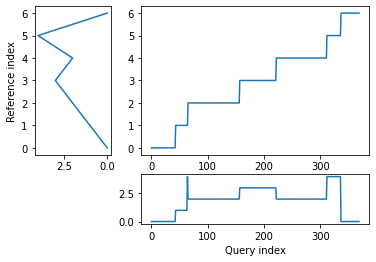

1/1 - 14s - loss: 0.1480 - accuracy: 0.9486
[Before DTW] 
               precision    recall  f1-score   support

         sit       0.91      1.00      0.95        69
sit-to-stand       0.81      0.74      0.77        23
        walk       0.99      0.95      0.97       190
        turn       0.98      0.97      0.98        66
stand-to-sit       0.81      0.95      0.88        22

    accuracy                           0.95       370
   macro avg       0.90      0.92      0.91       370
weighted avg       0.95      0.95      0.95       370

------------------------------
[After DTW] 
               precision    recall  f1-score   support

         sit       0.91      1.00      0.95        69
sit-to-stand       0.77      0.74      0.76        23
        walk       0.99      0.95      0.97       190
        turn       0.98      0.97      0.98        66
stand-to-sit       0.84      0.95      0.89        22

    accuracy                           0.95       370
   macro avg       0.90    

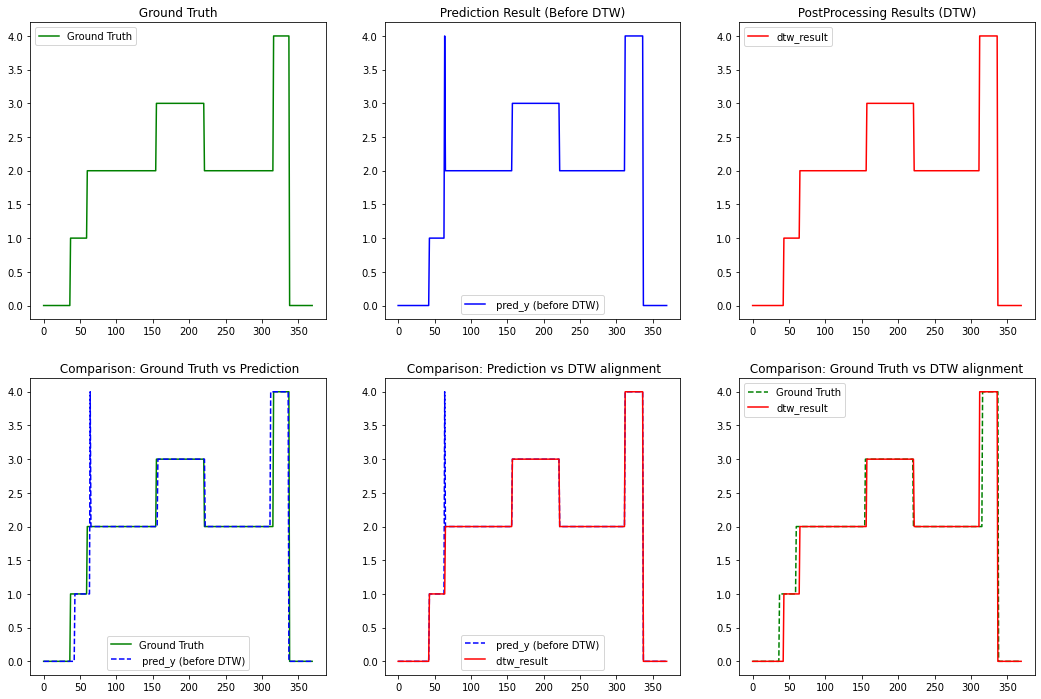

In [6]:
test_normal_30 = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2020_11_20_v2 TUG/cyj2/03/Originact5_lpf_labeled_cyj2_03.csv"
test_normal_30_x, test_normal_30_y_onehot = create_testdata(test_normal_30) 
test_normal_30_y = np.argmax(test_normal_30_y_onehot, axis=1).reshape(-1) # one-hot decode

pred_normal_30_onehot = model.predict(test_normal_30_x)
pred_normal_30_y = np.argmax(pred_normal_30_onehot, axis=1)

normal_30_alignment, normal_30_results = post_process_DTW(pred_normal_30_y, answer_y)
normal_30_alignment.plot(type="threeway")
plot_postResults(test_normal_30_y, pred_normal_30_y, normal_30_results, title="normal_30")



# ----- [Before DTW] Model Test
norm_30_eval = model.evaluate(test_normal_30_x, test_normal_30_y_onehot,batch_size= batch_size,verbose=2)
print("[Before DTW] \n", classification_report(test_normal_30_y, pred_normal_30_y, target_names=target_names))
print("------------------------------")
print("[After DTW] \n", classification_report(test_normal_30_y, normal_30_results, target_names=target_names))

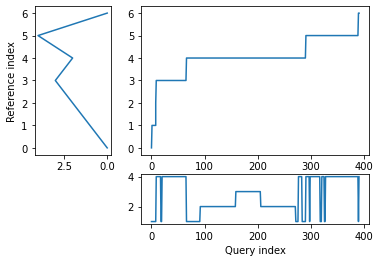

1/1 - 14s - loss: 1.5594 - accuracy: 0.5255
[Before DTW] 
               precision    recall  f1-score   support

         sit       0.00      0.00      0.00       167
sit-to-stand       0.27      1.00      0.42        15
        walk       0.99      0.96      0.97       138
        turn       0.96      1.00      0.98        45
stand-to-sit       0.09      0.52      0.15        27

    accuracy                           0.53       392
   macro avg       0.46      0.70      0.51       392
weighted avg       0.48      0.53      0.48       392

------------------------------
[After DTW] 
               precision    recall  f1-score   support

         sit       1.00      0.01      0.02       167
sit-to-stand       0.00      0.00      0.00        15
        walk       0.61      1.00      0.76       138
        turn       0.00      0.00      0.00        45
stand-to-sit       0.06      0.22      0.10        27

    accuracy                           0.37       392
   macro avg       0.33    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


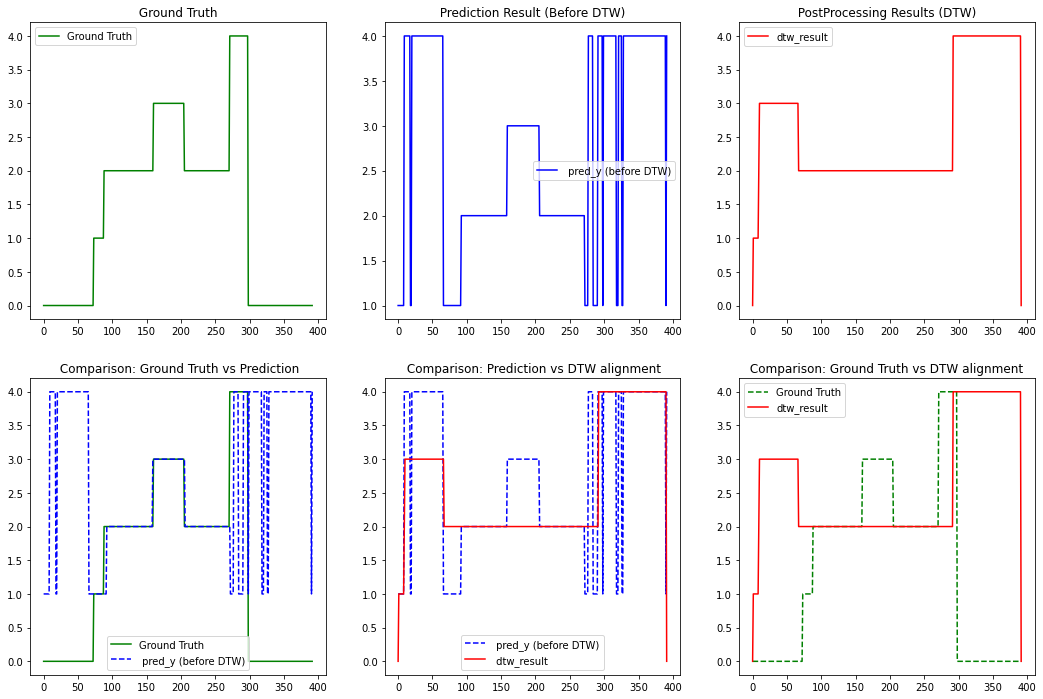

In [7]:
test_normal_60 = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2021_02_09 TUG/UMS_TUG/07/Originact5_lpf_labeled_UMS_TUG_07.csv"
test_normal_60_x, test_normal_60_y_onehot = create_testdata(test_normal_60) 
test_normal_60_y = np.argmax(test_normal_60_y_onehot, axis=1).reshape(-1) # one-hot decode

pred_normal_60_onehot = model.predict(test_normal_60_x)
pred_normal_60_y = np.argmax(pred_normal_60_onehot, axis=1).reshape(-1)

normal_60_alignment, normal_60_results = post_process_DTW(pred_normal_60_y, answer_y)
normal_60_alignment.plot(type="threeway")
plot_postResults(test_normal_60_y, pred_normal_60_y, normal_60_results, title="normal_60")


# ----- [Before DTW] Model Test
norm_60_eval = model.evaluate(test_normal_60_x, test_normal_60_y_onehot, batch_size= batch_size,verbose=2)
print("[Before DTW] \n", classification_report(test_normal_60_y, pred_normal_60_y, target_names=target_names))
print("------------------------------")
print("[After DTW] \n", classification_report(test_normal_60_y, normal_60_results, target_names=target_names))

###  Stroke -- 보조필요 없는 수준의 편마비, 케인/지팡이 사용,  모방 보행

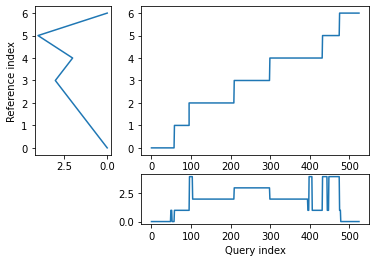

2/2 - 0s - loss: 0.4847 - accuracy: 0.8171
[Before DTW] 
               precision    recall  f1-score   support

         sit       0.96      0.97      0.97       101
sit-to-stand       0.45      0.92      0.61        38
        walk       1.00      0.71      0.83       283
        turn       0.64      1.00      0.78        58
stand-to-sit       0.67      0.82      0.74        45

    accuracy                           0.82       525
   macro avg       0.75      0.88      0.79       525
weighted avg       0.89      0.82      0.83       525

------------------------------
[After DTW] 
               precision    recall  f1-score   support

         sit       0.94      1.00      0.97       101
sit-to-stand       0.92      0.92      0.92        38
        walk       1.00      0.87      0.93       283
        turn       0.64      1.00      0.78        58
stand-to-sit       0.98      0.93      0.95        45

    accuracy                           0.92       525
   macro avg       0.90     

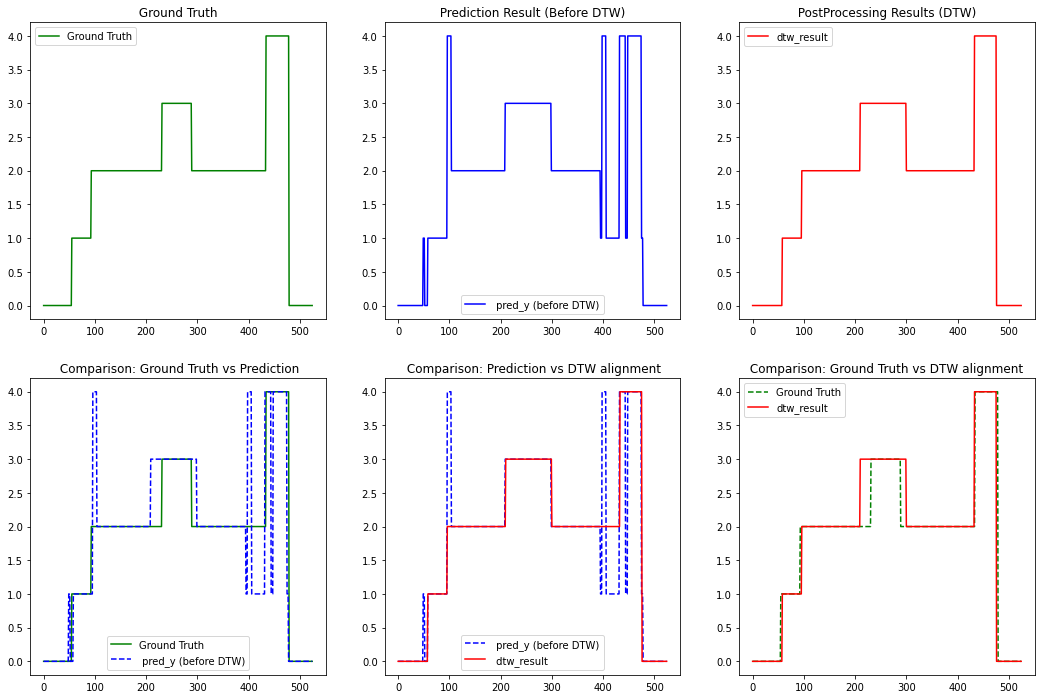

In [9]:
test_stroke_1 =  "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2020_12_09 TUG/JDW_tug/01/Originact5_lpf_labeled_JDW_tug_01.csv"
test_stroke_1_x, test_stroke_1_y_onehot = create_testdata(test_stroke_1)  
test_stroke_1_y = np.argmax(test_stroke_1_y_onehot, axis=1).reshape(-1) # one-hot decode

pred_stroke_1_one_hot = model.predict(test_stroke_1_x)
pred_stroke_1_y = np.argmax(pred_stroke_1_one_hot, axis=1)

stroke_1_alignment, stroke_1_results = post_process_DTW(pred_stroke_1_y, answer_y)
stroke_1_alignment.plot(type="threeway")
plot_postResults(test_stroke_1_y, pred_stroke_1_y, stroke_1_results, title="stroke_1")


# # ----- [Before DTW] Model Test
stroke_1_eval = model.evaluate(test_stroke_1_x, test_stroke_1_y_onehot, batch_size= batch_size,verbose=2)
print("[Before DTW] \n", classification_report(test_stroke_1_y, pred_stroke_1_y, target_names=target_names))
print("------------------------------")
print("[After DTW] \n", classification_report(test_stroke_1_y, stroke_1_results, target_names=target_names))

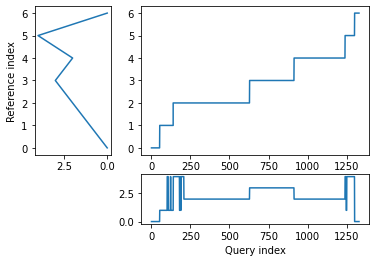

3/3 - 14s - loss: 0.3456 - accuracy: 0.8738
[Before DTW] 
               precision    recall  f1-score   support

         sit       0.76      1.00      0.86        62
sit-to-stand       0.93      0.56      0.70       147
        walk       1.00      0.89      0.94       840
        turn       0.77      1.00      0.87       220
stand-to-sit       0.39      0.81      0.53        62

    accuracy                           0.87      1331
   macro avg       0.77      0.85      0.78      1331
weighted avg       0.92      0.87      0.88      1331

------------------------------
[After DTW] 
               precision    recall  f1-score   support

         sit       0.77      1.00      0.87        62
sit-to-stand       1.00      0.59      0.74       147
        walk       0.94      0.92      0.93       840
        turn       0.77      1.00      0.87       220
stand-to-sit       0.90      0.89      0.89        62

    accuracy                           0.90      1331
   macro avg       0.88    

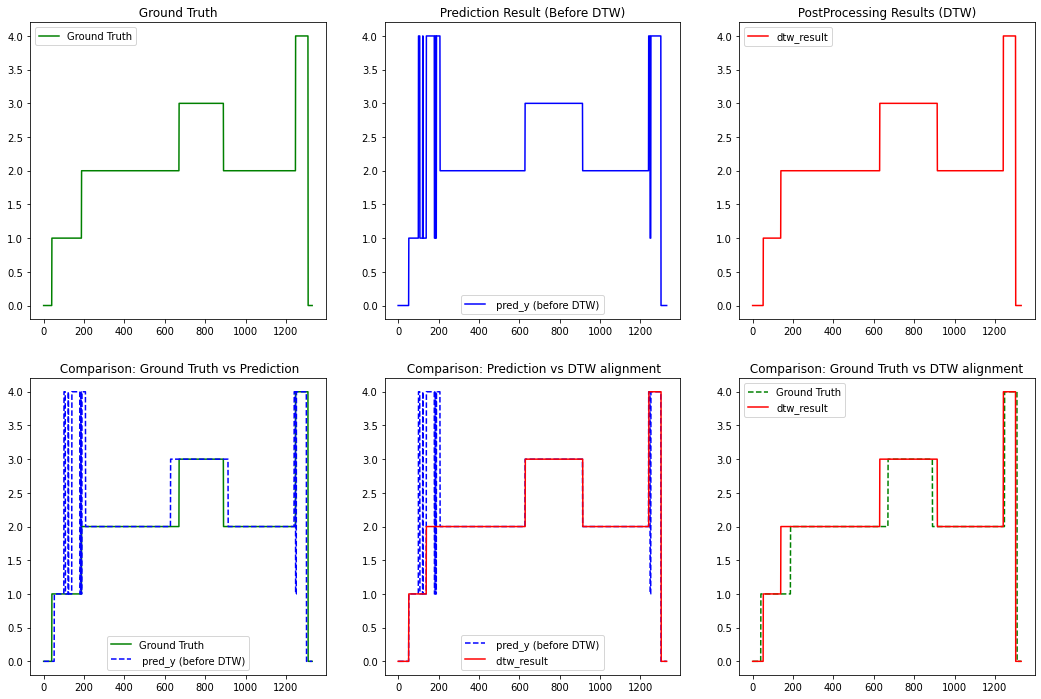

In [10]:
test_stroke_tool = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2021_01_20 TUG/KSG_TUG/02/Originact5_lpf_labeled_KSG_TUG_02.csv"
test_stroke_tool_x, test_stroke_tool_y_onehot = create_testdata(test_stroke_tool) 
test_stroke_tool_y = np.argmax(test_stroke_tool_y_onehot, axis=1).reshape(-1) #one-hot decode

pred_stroke_tool_onehot = model.predict(test_stroke_tool_x)
pred_stroke_tool_y = np.argmax(pred_stroke_tool_onehot, axis=1)

stroke_tool_alignment, stroke_tool_results = post_process_DTW(pred_stroke_tool_y, answer_y)
stroke_tool_alignment.plot(type="threeway")
plot_postResults(test_stroke_tool_y, pred_stroke_tool_y, stroke_tool_results, title="stroke_tool")


# ----- [Before DTW] Model Test
stroke_tool_eval = model.evaluate(test_stroke_tool_x, test_stroke_tool_y_onehot,batch_size= batch_size,verbose=2)
print("[Before DTW] \n", classification_report(test_stroke_tool_y, pred_stroke_tool_y, target_names=target_names))
print("------------------------------")
print("[After DTW] \n", classification_report(test_stroke_tool_y, stroke_tool_results, target_names=target_names))

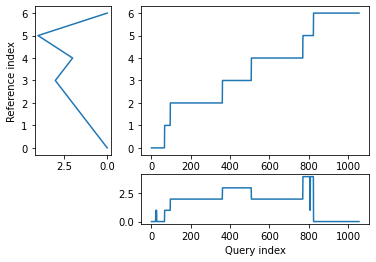

3/3 - 0s - loss: 0.2453 - accuracy: 0.9252
[Before DTW] 
               precision    recall  f1-score   support

         sit       0.98      0.98      0.98       294
sit-to-stand       0.83      0.67      0.74        43
        walk       0.94      0.93      0.94       537
        turn       0.73      1.00      0.85       108
stand-to-sit       1.00      0.72      0.83        74

    accuracy                           0.93      1056
   macro avg       0.90      0.86      0.87      1056
weighted avg       0.93      0.93      0.93      1056

------------------------------
[After DTW] 
               precision    recall  f1-score   support

         sit       0.98      1.00      0.99       294
sit-to-stand       1.00      0.67      0.81        43
        walk       0.94      0.93      0.94       537
        turn       0.73      1.00      0.85       108
stand-to-sit       1.00      0.73      0.84        74

    accuracy                           0.93      1056
   macro avg       0.93     

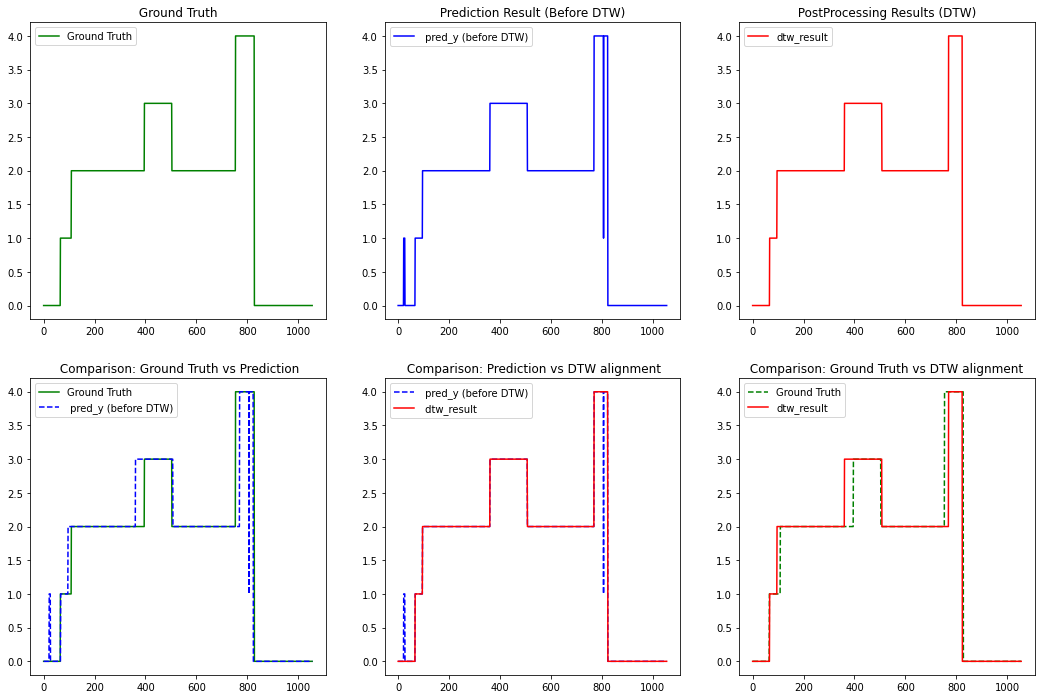

In [11]:
test_copy_stroke = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2020_12_30 TUG/YSJ_TUG/03/Originact5_lpf_labeled_YSJ_TUG_03.csv"
test_copy_stroke_x, test_copy_stroke_y_onehot = create_testdata(test_copy_stroke) 
test_copy_stroke_y = np.argmax(test_copy_stroke_y_onehot, axis=1).reshape(-1) #one-hot decode

pred_copy_stroke_onehot = model.predict(test_copy_stroke_x)
pred_copy_stroke_y = np.argmax(pred_copy_stroke_onehot, axis=1)


copy_stroke_alignment, copy_stroke_results = post_process_DTW(pred_copy_stroke_y, answer_y)
copy_stroke_alignment.plot(type="threeway")
plot_postResults(test_copy_stroke_y, pred_copy_stroke_y, copy_stroke_results, title="copy_stroke")


# ----- [Before DTW] Model Test
copy_stroke_eval = model.evaluate(test_copy_stroke_x, test_copy_stroke_y_onehot,batch_size= batch_size,verbose=2)
print("[Before DTW] \n", classification_report(test_copy_stroke_y, pred_copy_stroke_y, target_names=target_names))
print("------------------------------")
print("[After DTW] \n", classification_report(test_copy_stroke_y, copy_stroke_results, target_names=target_names))